# 概要

このノートブックでは,
pytorchを用いてMLPの実装を行う

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#データの生成
np.random.seed(0)
data1 = np.random.randn(100, 2)+np.array([2,4])
data2 = np.random.randn(100, 2)+np.array([4,2])
data = np.r_[data1, data2]
y = np.r_[np.zeros(100), np.ones(100)]

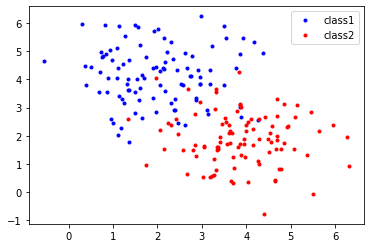

In [3]:
#データ分布の可視化
plt.figure()
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

## Multi-layer perceptron

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, *dims):
        super().__init__()
        self.depth = len(dims)
        self.units = dims
        
        for i in range(self.depth-1):
            layer = nn.Linear(self.units[i], self.units[i+1])
            nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
            setattr(self, f'fc{i+1}', layer)
    
    def forward(self, x):
        out = x
        for i in range(self.depth-2):
            out = F.relu(getattr(self,f'fc{i+1}')(out))
        return getattr(self, f'fc{self.depth-1}')(out)

In [5]:
from torch.autograd import Variable
import torch.utils.data
from tqdm import tqdm
import time

class Solver(object):
    def __init__(self, structure=[2, 50, 2], max_epoch = 10, batch_size = 128):
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")
        else:
            self.device = torch.device("cpu")
            
        self.model = MLP(*structure).to(self.device)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters())
        
    def fit(self, train_X, train_Y):
        self.loss_list = []
        self.num_class = int(np.max(train_Y)+1)
        for epoch in tqdm(range(self.max_epoch)):
            time.sleep(0.1)
            self.loss_list.append(self._epoch_procedure(train_X, train_Y))
            
    def _epoch_procedure(self, train_X, train_Y):
        self.model.train()
        dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X).to(self.device), torch.from_numpy(train_Y).to(self.device))
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        running_loss = 0.0
        for idx, (inputs, labels) in enumerate(loader):
            inputs, labels = Variable(inputs).float(), Variable(labels).long()
            
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            running_loss += loss.item()
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return running_loss/len(loader)
    
    def predict_proba(self, test_X):
        self.model.eval()
        inputs = torch.from_numpy(test_X).to(self.device)
        loader = torch.utils.data.DataLoader(inputs, batch_size=1, shuffle=False)
        predict_proba=[]
        for idx, (inputs) in enumerate(loader):
            inputs = Variable(inputs).float()
            outputs = self.model(inputs)
            predict_proba.append(outputs.cpu().data.numpy())
        return np.array(predict_proba).reshape(-1, self.num_class)
    
    def predict(self, test_X):
        prob = self.predict_proba(test_X)
        return np.argmax(prob, axis = 1)
    
    def score(self, test_X, test_Y):
        predict_y = self.predict(test_X)
        return 100*np.sum(test_Y==predict_y)/len(predict_y)

In [6]:
solver = Solver(structure=[2, 100,100, 2], max_epoch=50, batch_size=128)
solver.fit(data, y)

100%|██████████| 50/50 [00:05<00:00,  9.34it/s]


In [7]:
print(f'score : {solver.score(data,y)}%')

score : 91.0%


In [8]:
from matplotlib.colors import LinearSegmentedColormap
def set_sklearn_backgound(cls, x_r, y_r):
    N = 100

    color_map = LinearSegmentedColormap.from_list("color_map", [
            (0.0, "#0877bd"),
            (1.0, "#f59322"),])

    X, Y = np.meshgrid(np.linspace(*x_r, N), np.linspace(*y_r, N))
    X = np.hstack(X)
    Y = np.hstack(Y)
    Z=np.dstack((X, Y)).reshape(-1, 2)
    Z = cls.predict(Z)
    Z=Z.reshape(N,N)
    X = X.reshape((N, -1))
    Y = Y.reshape((N, -1))

    plt.pcolor(X, Y, Z, cmap=color_map)

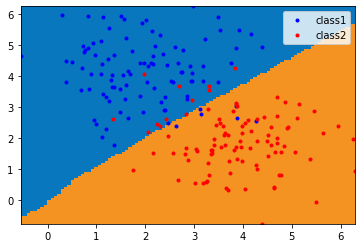

In [9]:
x_r = [min(data[:,0]), max(data[:,0])]
y_r = [min(data[:,1]), max(data[:,1])]
set_sklearn_backgound(solver, x_r, y_r)
plt.xlim(x_r)
plt.ylim(y_r)
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()